In [7]:
import torch
from torch import nn

from vits.model import commons
from vits.utils import utils
from vits.model.models import SynthesizerTrn
from vits.text.symbols import symbols
from vits.text import cleaned_text_to_sequence, text_to_sequence, batch_text_to_sequence

from scipy.io.wavfile import write

from sae.models.model import SparseAE
import numpy as np


def get_text(text, hps, language_code):
    text_norm = text_to_sequence(text, str(language_code))
    if hps.data.add_blank:
        text_norm = commons.intersperse(text_norm, 0) 
    text_norm = torch.LongTensor(text_norm)
    return text_norm

language_code = 0
device = 'cuda'

# inference setting & get h from a,b
hps = utils.get_hparams_from_file("vits/configs/vits_base.json")
checkpoint_name = "vits_pl_test"
model_name = "G_40000"
CUDA_LAUNCH_BLOCKING=1
net_g = SynthesizerTrn(
    len(symbols),
    hps.data.filter_length // 2 + 1,
    hps.train.segment_size // hps.data.hop_length,
    n_speakers=61,
    **hps.model).to(device)
_ = net_g.eval()

_ = utils.load_checkpoint(f"vits/checkpoints/{checkpoint_name}/{model_name}.pth", net_g, None)

sae = SparseAE(192, 192 * 16, 1.0, 0, True).to(device)
sae.load_state_dict(torch.load('/workspace/pl_tts/src/sae/checkpoints/vits_z/30epoch_5.0_0.1_0.05/sae_final.pth'))
sae.eval()



# fixed_texts = ["안녕하세요, 앞으로 잘 부탁드립니다.","오늘 날씨가 참 좋네요.", "이 프로젝트는 정말 기대돼요.", "혹시 시간 괜찮으시면 잠깐 이야기 나눌 수 있을까요?", "도움 주셔서 진심으로 감사드립니다."]
# fixed_texts = ["안녕안녕안녕안녕안녕안녕안녕안녕안녕안녕안녕"]
fixed_texts = ["잘가잘가잘가잘가잘가잘가잘가잘가잘가잘가잘가"]
high_pitch_speakers = ['23', '4']
low_pitch_speakers = ['35', '1']


def extract_h_from_text(text, speaker_id, vits_model, sae_model, hps, device):
    stn_text = get_text(text, hps, str(language_code))
    x_tst = stn_text.to(device).unsqueeze(0)
    x_tst_lengths = torch.LongTensor([stn_text.size(0)]).to(device)
    # 2. speaker id tensor
    sid = torch.LongTensor([int(speaker_id)]).to(device)

    # 3. Inference from VITS (get z latent)
    with torch.no_grad():
        z, y_mask, g, max_len = vits_model.infer(
            x_tst, x_tst_lengths, y=None, sid=sid,
            noise_scale=0, noise_scale_w=0, length_scale=1.0,
            return_z=True
        )
        # 4. SAE에 z를 통과시켜 h 획득
        h, _ = sae_model(z.squeeze(0).T)  # z: [1, D, T] → T x D
        h = h.mean(dim=0)
        return h.cpu().numpy()  # shape: [D]
    
def get_avg_h_for_speaker(sid, text_list):
    hs = [extract_h_from_text(text, sid, net_g, sae, hps, device) for text in text_list]
    # print(np.stack(hs).shape)
    return np.mean(np.stack(hs), axis=0)
    
# 각 그룹에서 평균 h 벡터 수집
h_high = [get_avg_h_for_speaker(sid, fixed_texts) for sid in high_pitch_speakers]
h_low  = [get_avg_h_for_speaker(sid, fixed_texts) for sid in low_pitch_speakers]

# # ⛳ 핵심 수정
# h_high_mean = np.mean(np.stack(h_high), axis=0)
# h_low_mean  = np.mean(np.stack(h_low), axis=0)

# diff = np.abs(h_high_mean - h_low_mean)
# top_dims = np.argsort(diff)[-10:][::-1]
# for i in top_dims:
#     print(f"Dim {i}: high={h_high_mean[i]:.4f}, low={h_low_mean[i]:.4f}, diff={diff[i]:.4f}")



# Pitch overall: μ=224.41 Hz, σ=20.02 Hz
# Thresholds: >254.44 Hz (high), <194.37 Hz (low)
# High-pitch speakers: ['23', '4']
# Low-pitch speakers:  ['46', '35', '1', '6', '18']

# Energy overall: μ=0.04724, σ=0.00925
# Thresholds: >0.06111 (high), <0.03336 (low)
# High-energy speakers: ['7', '40', '42']
# Low-energy speakers:  ['46', '20', '38', '37']

# Pitch overall: μ=224.41 Hz, σ=20.02 Hz
# Thresholds: >264.45 Hz (high), <184.36 Hz (low)
# High-pitch speakers: ['23', '4']
# Low-pitch speakers:  ['35', '1']


/root/anaconda3/envs/pl_tts/lib/python3.9/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
/workspace/pl_tts/src/vits/utils/utils.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_onl

INFO:root:Loaded checkpoint 'vits/checkpoints/vits_pl_test/G_40000.pth' (iteration 57)


/tmp/ipykernel_35904/2194761566.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sae.load_state_dict(torch.load('/workspace/pl_tts/src/sae/checkpoints/vits_z/30epoch_5.0

In [4]:
# h_test = h_high[0].squeeze(0)

# for h in h_test:
#     print(sum(h > 0.05))
    
# print(sum(h_test.mean(axis=0) > 0.05))

Top-k pitch-sensitive dimensions: [1260 1753  415 1488 2405 2947 2546 1301 2579 2180]


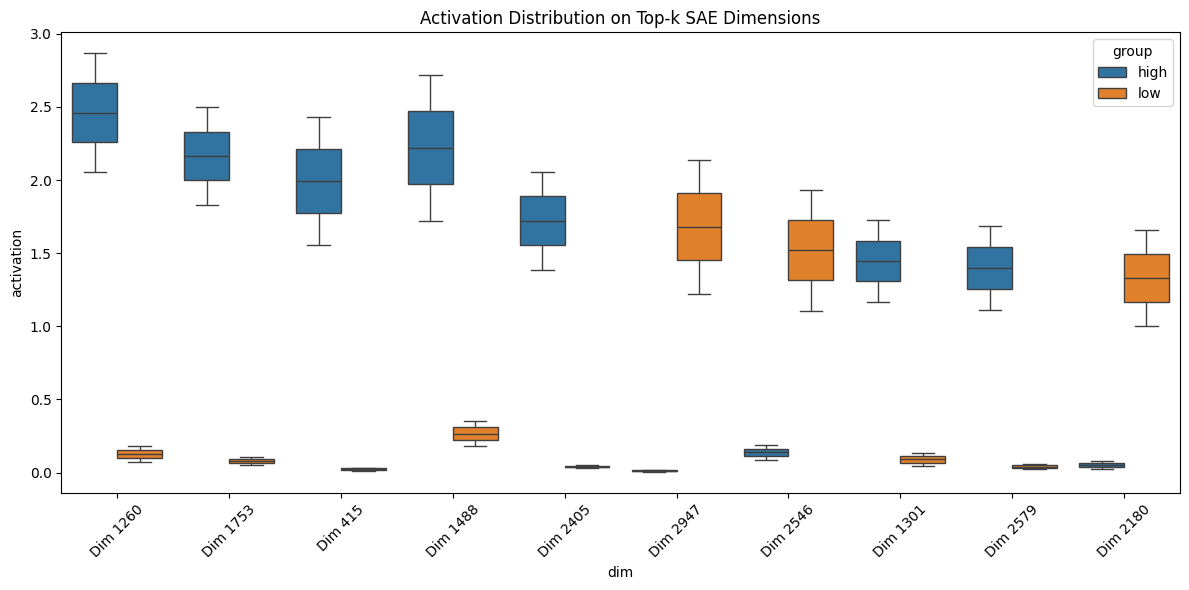

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd



# 1) 그룹 평균 벡터 계산
high_matrix = np.stack(h_high)  # shape: [n_high, D]
low_matrix  = np.stack(h_low)   # shape: [n_low,  D]

high_mean = high_matrix.mean(axis=0)
low_mean = low_matrix.mean(axis=0)

# high_mean[high_mean < 2.0] = 0.0
# low_mean[low_mean < 2.0] = 0.0

# high_low = {}

# for i in range(len(high_matrix)):
#     high_mean = high_matrix[i]
#     for j in range(len(low_matrix)):
#         low_mean = low_matrix[j]
        
#         diff = np.abs(high_mean - low_mean)
#         k = 10
#         top_dims = np.argsort(diff)[-k:][::-1]
        
#         for dim in top_dims:
#             if dim not in high_low:
#                 high_low[int(dim)] = 0
#             high_low[int(dim)] += 1

#         # print("Top-k pitch-sensitive dimensions:", top_dims)
    
# sorted_hl = dict(sorted(high_low.items(), key=lambda item: item[1], reverse=True))

# for key in sorted_hl:
#     print(f"{key} : {sorted_hl[key]}")
        

        
diff = np.abs(high_mean - low_mean)
k = 10
top_dims = np.argsort(diff)[-k:][::-1]

print("Top-k pitch-sensitive dimensions:", top_dims)

# for dim in top_dims:
#     print(f"{int(dim)} - {high_mean[int(dim)]} : {low_mean[int(dim)]} = {high_mean[int(dim)] / low_mean[int(dim)]}")


# 2) 차이가 큰 top-k 차원 추출

# 3) 각 화자별 해당 차원 activation 모아서 DataFrame으로 변환
rows = []
for sid, vecs in [("high", h_high), ("low", h_low)]:
    speakers = high_pitch_speakers if sid=="high" else low_pitch_speakers
    for spk, h_vec in zip(speakers, vecs):
        for d in top_dims:
            rows.append({
                "speaker": spk,
                "group": sid,
                "dim": f"Dim {d}",
                "activation": h_vec[d]
            })

df = pd.DataFrame(rows)

# 4) Boxplot 그리기
plt.figure(figsize=(12,6))
sns.boxplot(x="dim", y="activation", hue="group", data=df)
plt.xticks(rotation=45)
plt.title("Activation Distribution on Top-k SAE Dimensions")
plt.tight_layout()
plt.show()

In [9]:
import os
import numpy as np

# ─── 설정 ─────────────────────────────────────────────────────────────
# 앞서 저장한 디렉터리 경로
data_dir = "/workspace/pl_tts/src/sae/all_speakers_h_and_f0_2"

# 처리할 화자 ID 리스트 (0부터 60까지)
speaker_ids = [str(i) for i in range(61)]
# ─────────────────────────────────────────────────────────────────────────

def pearson_corr(x: np.ndarray, y: np.ndarray) -> float:
    """
    1차원 배열 x, y에 대해 Pearson 상관계수 반환.
    """
    xm = x.mean()
    ym = y.mean()
    xm2 = ((x - xm) ** 2).sum()
    ym2 = ((y - ym) ** 2).sum()
    cov = ((x - xm) * (y - ym)).sum()
    return cov / np.sqrt(xm2 * ym2 + 1e-8)

def main():
    # ─ 1) 화자별 h_mean (D_h)와 avg_f0 모으기 ──────────────────────
    h_list = []
    f0_list = []
    for spk in speaker_ids:
        # 각 화자 파일 경로
        h_path = os.path.join(data_dir, f"speaker_{spk}_h.npy")
        f0_path = os.path.join(data_dir, f"speaker_{spk}_avg_f0.npy")
        if not os.path.isfile(h_path) or not os.path.isfile(f0_path):
            raise FileNotFoundError(f"Missing files for speaker {spk}")

        # (T_z, D_h) 형상의 latent 시퀀스 로드
        h_all = np.load(h_path)           # shape: (T_z, D_h)
        # 화자별 평균 피치 (스칼라)
        avg_f0 = float(np.load(f0_path))   # scalar

        # 시퀀스 평균: (D_h,)
        mu_h = h_all.mean(axis=0)

        h_list.append(mu_h)
        f0_list.append(avg_f0)

    # numpy 배열로 변환
    h_means = np.stack(h_list, axis=0)  # shape: (61, D_h)
    f0_means = np.array(f0_list)        # shape: (61,)

    # ─ 2) 차원별 상관계수 계산 ────────────────────────────────────
    num_speakers, D_h = h_means.shape
    corrs = np.zeros(D_h)

    for d in range(D_h):
        corrs[d] = pearson_corr(h_means[:, d], f0_means)

    #  절댓값 기준 상위 k개 차원 뽑기 ───────────────────────────
    k = 10
    topk_idxs = np.argsort(np.abs(corrs))[-k:][::-1]

    # 결과 출력
    print(f"화자 수: {num_speakers}, latent 차원 수: {D_h}")
    print(f"\n상위 {k}개 차원 (절댓값 상관계수 기준):")
    for rank, d in enumerate(topk_idxs, 1):
        print(f"{rank:2d}. Dim {d}: corr = {corrs[d]:.4f}")


if __name__ == "__main__":
    main()


화자 수: 61, latent 차원 수: 3072

상위 10개 차원 (절댓값 상관계수 기준):
 1. Dim 1488: corr = 0.8924
 2. Dim 2405: corr = 0.8911
 3. Dim 1260: corr = 0.8909
 4. Dim 2579: corr = 0.8901
 5. Dim 197: corr = 0.8797
 6. Dim 1301: corr = 0.8552
 7. Dim 415: corr = 0.8505
 8. Dim 2947: corr = -0.8457
 9. Dim 1753: corr = 0.8393
10. Dim 257: corr = -0.8117


In [ ]:
#[1753  415 1260 2395 2546    1  378 1488 2947 2180]

In [6]:
import os
import numpy as np

# ─── 설정 ─────────────────────────────────────────────────────────────
# 앞서 저장한 디렉터리 경로
data_dir = "/workspace/pl_tts/src/sae/all_speakers_h_and_f0"

# 처리할 화자 ID 리스트 (0부터 60까지)
speaker_ids = [str(i) for i in range(61)]
# ─────────────────────────────────────────────────────────────────────────

def pearson_corr(x: np.ndarray, y: np.ndarray) -> float:
    """
    1차원 배열 x, y에 대해 Pearson 상관계수 반환.
    """
    xm = x.mean()
    ym = y.mean()
    xm2 = ((x - xm) ** 2).sum()
    ym2 = ((y - ym) ** 2).sum()
    cov = ((x - xm) * (y - ym)).sum()
    return cov / np.sqrt(xm2 * ym2 + 1e-8)

def main():
    # ─ 1) 화자별 h_mean (D_h)와 avg_f0 모으기 ──────────────────────
    h_list = []
    f0_list = []
    for spk in speaker_ids:
        # 각 화자 파일 경로
        h_path = os.path.join(data_dir, f"speaker_{spk}_h.npy")
        f0_path = os.path.join(data_dir, f"speaker_{spk}_avg_f0.npy")
        if not os.path.isfile(h_path) or not os.path.isfile(f0_path):
            raise FileNotFoundError(f"Missing files for speaker {spk}")

        # (T_z, D_h) 형상의 latent 시퀀스 로드
        h_all = np.load(h_path)           # shape: (T_z, D_h)
        # 화자별 평균 피치 (스칼라)
        avg_f0 = float(np.load(f0_path))   # scalar

        # 시퀀스 평균: (D_h,)
        mu_h = h_all.mean(axis=0)

        h_list.append(mu_h)
        f0_list.append(avg_f0)

    # numpy 배열로 변환
    h_means = np.stack(h_list, axis=0)  # shape: (61, D_h)
    f0_means = np.array(f0_list)        # shape: (61,)

    # ─ 2) 차원별 상관계수 계산 ────────────────────────────────────
    num_speakers, D_h = h_means.shape
    corrs = np.zeros(D_h)

    for d in range(D_h):
        corrs[d] = pearson_corr(h_means[:, d], f0_means)

    #  절댓값 기준 상위 k개 차원 뽑기 ───────────────────────────
    k = 10
    topk_idxs = np.argsort(np.abs(corrs))[-k:][::-1]

    # 결과 출력
    print(f"화자 수: {num_speakers}, latent 차원 수: {D_h}")
    print(f"\n상위 {k}개 차원 (절댓값 상관계수 기준):")
    for rank, d in enumerate(topk_idxs, 1):
        print(f"{rank:2d}. Dim {d}: corr = {corrs[d]:.4f}")


if __name__ == "__main__":
    main()


화자 수: 61, latent 차원 수: 3072

상위 10개 차원 (절댓값 상관계수 기준):
 1. Dim 1260: corr = 0.9347
 2. Dim 1301: corr = 0.9314
 3. Dim 2405: corr = 0.9181
 4. Dim 2579: corr = 0.9152
 5. Dim 197: corr = 0.9116
 6. Dim 1488: corr = 0.9080
 7. Dim 2268: corr = 0.8832
 8. Dim 2947: corr = -0.8762
 9. Dim 775: corr = 0.8452
10. Dim 1234: corr = 0.8278


[1753 2243 2546 2395  378  415 2180    1 2947  257]


상위 10개 차원 (절댓값 상관계수 기준):
 1. Dim 2395: corr = 0.8833
 2. Dim 1753: corr = 0.8784
 3. Dim 754: corr = 0.8784
 4. Dim 415: corr = 0.8749
 5. Dim 1: corr = 0.8604
 6. Dim 1234: corr = 0.8393
 7. Dim 378: corr = 0.8374
 8. Dim 2569: corr = 0.8373
 9. Dim 2947: corr = -0.8335
10. Dim 257: corr = -0.8284